# Load Dataset

In [1]:
!pip install kaggle

!kaggle datasets download -d dhruvildave/new-york-city-taxi-trips-2019 -p /content/taxi_data

!unzip /content/taxi_data/new-york-city-taxi-trips-2019.zip -d /content/taxi_data

Dataset URL: https://www.kaggle.com/datasets/dhruvildave/new-york-city-taxi-trips-2019
License(s): ODC Attribution License (ODC-By)
new-york-city-taxi-trips-2019.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Import necessary librarires

In [2]:
pip install --upgrade numba umap-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

# Set global styling
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams.update({"figure.dpi": 120})




# Step 1: Data Loading and Precproceesing

In [4]:
import pandas as pd
import sqlite3
import numpy as np
import os

def get_table_name(conn):
    """Retrieve the first available table name from the SQLite database."""
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table = cursor.fetchone()  # Get the first table
    return table[0] if table else None

def load_and_sample(data_dir, sample_frac=0.15):
    """Load and sample data from SQLite files."""
    all_dfs = []
    
    # Check if the directory exists
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory does not exist: {data_dir}")
    
    for file in os.listdir(data_dir):
        if file.endswith(".sqlite"):
            file_path = os.path.join(data_dir, file)
            conn = sqlite3.connect(file_path)
            
            table_name = get_table_name(conn)
            if not table_name:
                print(f"No table found in {file}")
                conn.close()
                continue
            
            print(f"Reading from table: {table_name} in {file}")
            
            chunksize = 100_000  # Process 100k rows at a time

            # Read in chunks to avoid memory overflow
            for df_chunk in pd.read_sql(
                f"SELECT * FROM {table_name}", conn, chunksize=chunksize
            ):
                # Ensure datetime conversion
                if 'tpep_pickup_datetime' in df_chunk.columns:
                    df_chunk['tpep_pickup_datetime'] = pd.to_datetime(df_chunk['tpep_pickup_datetime'])
                    df_chunk['pickup_hour'] = df_chunk['tpep_pickup_datetime'].dt.hour
                else:
                    print(f"Column 'tpep_pickup_datetime' not found in {file}")
                    continue

                # Create fare_class
                if 'fare_amount' in df_chunk.columns:
                    bins = [-np.inf, 10, 30, 60, np.inf]
                    labels = ["Class 1", "Class 2", "Class 3", "Class 4"]
                    df_chunk['fare_class'] = pd.cut(
                        df_chunk['fare_amount'],
                        bins=bins,
                        labels=labels,
                        right=True,
                        include_lowest=True
                    )
                else:
                    print(f"Column 'fare_amount' not found in {file}")
                    continue

                # Stratified sampling
                stratified = df_chunk.groupby(
                    by=['fare_class', 'pickup_hour'],
                    observed=True
                ).apply(
                    lambda x: x.sample(frac=sample_frac, random_state=42),
                    include_groups=False
                ).reset_index(drop=True)

                all_dfs.append(stratified)
            
            conn.close()

    if not all_dfs:
        raise ValueError("No valid data was found in the database files.")

    return pd.concat(all_dfs, ignore_index=True)

# Usage
df = load_and_sample(r"C:\Users\mceka\Desktop\Wa-vjezbe\Data-Science\data\2019", sample_frac=0.10)

# Display the first few rows
print(df.head())


Reading from table: tripdata in 2019-02.sqlite
   vendorid tpep_pickup_datetime       tpep_dropoff_datetime  passenger_count  \
0       2.0  2019-02-01 00:37:54  2019-02-01 00:44:58.000000              1.0   
1       2.0  2019-02-01 00:29:02  2019-02-01 00:37:14.000000              5.0   
2       1.0  2019-02-01 00:04:39  2019-02-01 00:17:32.000000              1.0   
3       1.0  2019-02-01 00:05:30  2019-02-01 00:09:17.000000              1.0   
4       1.0  2019-02-01 00:24:04  2019-02-01 00:30:14.000000              1.0   

   trip_distance  ratecodeid store_and_fwd_flag  pulocationid  dolocationid  \
0           1.69         1.0                  N         230.0         164.0   
1           2.55         1.0                  N         162.0          79.0   
2           0.70         1.0                  N         148.0         144.0   
3           0.60         1.0                  Y         264.0         264.0   
4           1.10         1.0                  N         255.0         1

In [5]:
df.describe()

,vendorid,tpep_pickup_datetime,passenger_count,trip_distance,ratecodeid,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,701754.000000,701754,701754.000000,701754.000000,701754.000000,701754.000000,701754.000000,701754.000000,701754.000000,701754.000000,701754.000000,701754.00000,701754.000000,701754.000000,701754.000000,701754.000000
mean,1.634127,2019-02-14 22:56:54.733615872,1.569014,2.884526,1.061292,163.412372,161.672099,1.270498,12.634363,1.162083,0.495979,2.16191,0.340804,0.299088,18.440461,2.173098
min,1.000000,2008-12-31 22:11:13,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-170.000000,-4.500000,-0.500000,-47.30000,-10.500000,-0.300000,-170.300000,-2.500000
25%,1.000000,2019-02-07 19:39:02.249999872,1.000000,0.940000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.00000,0.000000,0.300000,11.000000,2.500000
50%,2.000000,2019-02-14 17:07:59,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.000000,0.500000,0.500000,1.86000,0.000000,0.300000,14.160000,2.500000
75%,2.000000,2019-02-22 04:34:59,2.000000,2.910000,1.000000,233.000000,234.000000,2.000000,14.000000,2.500000,0.500000,2.86000,0.000000,0.300000,19.800000,2.500000
max,4.000000,2038-02-17 21:55:54,8.000000,226.100000,99.000000,265.000000,265.000000,4.000000,750.000000,17.500000,0.500000,250.00000,99.000000,1.000000,750.300000,2.750000
std,0.525023,NaN,1.226033,3.774379,0.664311,65.957419,70.073770,0.466993,11.459330,1.268331,0.051454,2.61240,1.518555,0.022734,14.018925,0.847889


In [6]:
import pandas as pd
import numpy as np

# --- Data Cleaning ---

# 1. Drop duplicates
df.drop_duplicates(inplace=True)

# 2. Handle missing values
# Drop rows where critical columns have missing values
critical_columns = [
    "fare_amount",
    "trip_distance",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "pulocationid",  # Pickup location ID
    "dolocationid"   # Dropoff location ID
]
df.dropna(subset=critical_columns, inplace=True)

# 3. Convert datetime columns
# Ensure pickup and dropoff datetimes are valid
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")

# Drop rows with invalid datetime values
df = df[
    (df["tpep_pickup_datetime"].notnull()) &
    (df["tpep_dropoff_datetime"].notnull())
]

# 4. Calculate trip duration (in minutes)
df["trip_duration"] = (
    (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
)

# 5. Remove outliers
# - Filter trips within 2019 (dataset is for 2019)
df = df[
    (df["tpep_pickup_datetime"].dt.year == 2019) &
    (df["tpep_dropoff_datetime"].dt.year == 2019)
]

# - Valid trip distance (0 < distance <= 100 miles)
# Adjusted based on `df.describe()` showing a max of ~311 miles
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= 100)]

# - Valid fare amount (0 < fare <= $500)
# Adjusted based on `df.describe()` showing a max of ~$411k (likely erroneous)
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] <= 500)]

# - Valid passenger count (1 <= passengers <= 6)
df = df[(df["passenger_count"] >= 1) & (df["passenger_count"] <= 6)]

# - Valid trip duration (0 < duration <= 1440 minutes (24 hours))
df = df[(df["trip_duration"] > 0) & (df["trip_duration"] <= 1440)]

# - Remove trips with negative or unrealistic tolls/tips
df = df[
    (df["tip_amount"] >= 0) &
    (df["tolls_amount"] >= 0) &
    (df["congestion_surcharge"] >= 0)
]

# 6. Encode `store_and_fwd_flag`
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"Y": 1, "N": 0})

# 7. Create fare classes for classification
bins = [-np.inf, 10, 30, 60, np.inf]
labels = ["Class 1", "Class 2", "Class 3", "Class 4"]
df["fare_class"] = pd.cut(df["fare_amount"], bins=bins, labels=labels)

# 8. Reset index
df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration,fare_class
0,2.0,2019-02-01 00:37:54,2019-02-01 00:44:58,1.0,1.69,1.0,0,230.0,164.0,1.0,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,7.066667,Class 1
1,2.0,2019-02-01 00:29:02,2019-02-01 00:37:14,5.0,2.55,1.0,0,162.0,79.0,1.0,9.5,0.5,0.5,2.16,0.0,0.3,12.96,0.0,8.200000,Class 1
2,1.0,2019-02-01 00:04:39,2019-02-01 00:17:32,1.0,0.70,1.0,0,148.0,144.0,2.0,9.0,0.5,0.5,0.00,0.0,0.3,10.30,0.0,12.883333,Class 1
3,1.0,2019-02-01 00:05:30,2019-02-01 00:09:17,1.0,0.60,1.0,1,264.0,264.0,1.0,4.5,0.5,0.5,1.15,0.0,0.3,6.95,0.0,3.783333,Class 1
4,1.0,2019-02-01 00:24:04,2019-02-01 00:30:14,1.0,1.10,1.0,0,255.0,112.0,2.0,6.0,0.5,0.5,0.00,0.0,0.3,7.30,0.0,6.166667,Class 1


In [8]:
df.describe()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
count,683822.000000,683822,683822,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000,683822.000000
mean,1.645541,2019-02-14 22:48:19.710698240,2019-02-14 23:05:36.456114688,1.598284,2.906986,1.051705,0.004845,163.330193,161.580753,1.263769,12.607016,1.143473,0.498006,2.161886,0.339851,0.299981,18.431797,2.188044,17.279090
min,1.000000,2019-01-31 16:11:54,2019-01-31 16:25:18,1.000000,0.010000,1.000000,0.000000,1.000000,1.000000,1.000000,0.010000,-2.500000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.016667
25%,1.000000,2019-02-07 19:34:59,2019-02-07 19:50:51,1.000000,0.960000,1.000000,0.000000,114.000000,111.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,11.150000,2.500000,6.533333
50%,2.000000,2019-02-14 17:02:22,2019-02-14 17:23:47,1.000000,1.600000,1.000000,0.000000,162.000000,162.000000,1.000000,9.000000,0.500000,0.500000,1.860000,0.000000,0.300000,14.160000,2.500000,10.850000
75%,2.000000,2019-02-22 04:24:26.750000128,2019-02-22 04:58:19.500000,2.000000,2.940000,1.000000,0.000000,233.000000,234.000000,2.000000,14.000000,2.500000,0.500000,2.860000,0.000000,0.300000,19.800000,2.500000,17.683333
max,4.000000,2019-07-05 23:11:29,2019-07-06 06:45:08,6.000000,86.640000,99.000000,1.000000,265.000000,265.000000,4.000000,450.000000,17.500000,0.500000,180.000000,95.760000,0.300000,450.300000,2.750000,1439.633333
std,0.522835,NaN,NaN,1.220284,3.762130,0.501576,0.069436,65.905634,70.035707,0.455175,10.972870,1.258902,0.031512,2.540916,1.502149,0.002379,13.550276,0.826175,70.448978


# Step 2: Exploratory Data Analysis (EDA)

Descriptive Statistics:
            vendorid  passenger_count  trip_distance     ratecodeid  \
count  683822.000000    683822.000000  683822.000000  683822.000000   
mean        1.645541         1.598284       2.906986       1.051705   
std         0.522835         1.220284       3.762130       0.501576   
min         1.000000         1.000000       0.010000       1.000000   
25%         1.000000         1.000000       0.960000       1.000000   
50%         2.000000         1.000000       1.600000       1.000000   
75%         2.000000         2.000000       2.940000       1.000000   
max         4.000000         6.000000      86.640000      99.000000   

       store_and_fwd_flag   pulocationid   dolocationid   payment_type  \
count       683822.000000  683822.000000  683822.000000  683822.000000   
mean             0.004845     163.330193     161.580753       1.263769   
std              0.069436      65.905634      70.035707       0.455175   
min              0.000000       1.000000

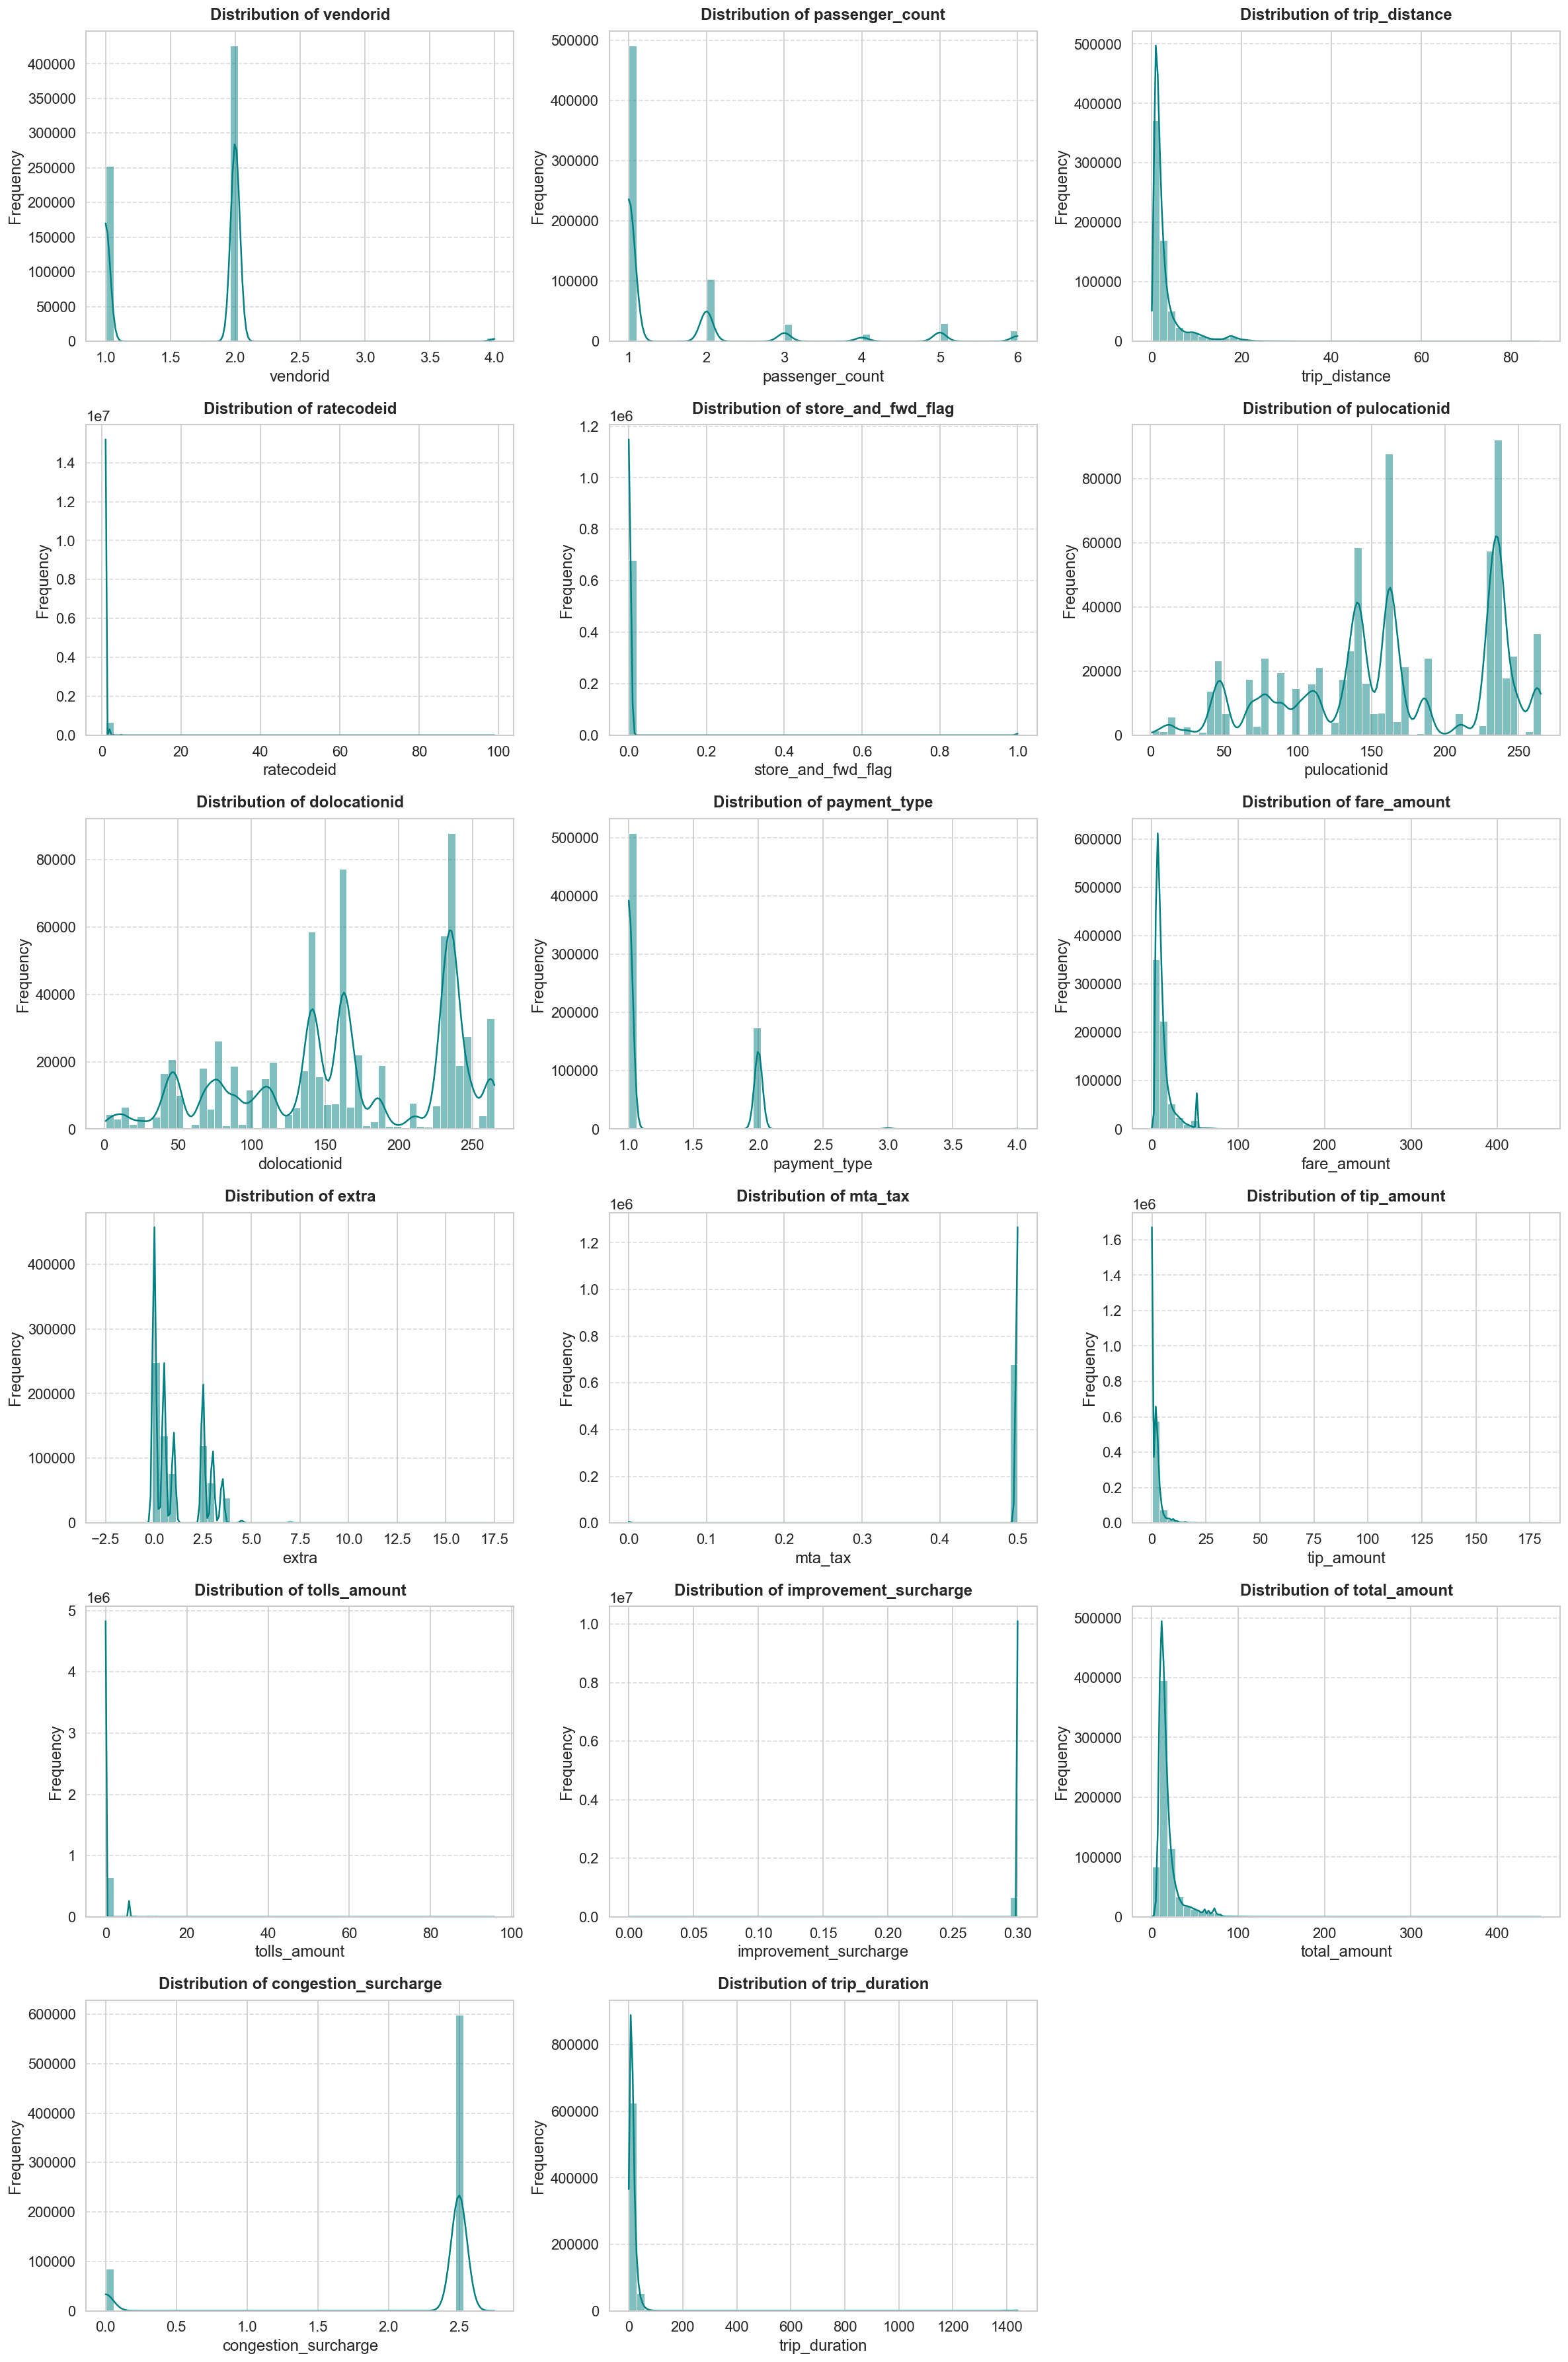

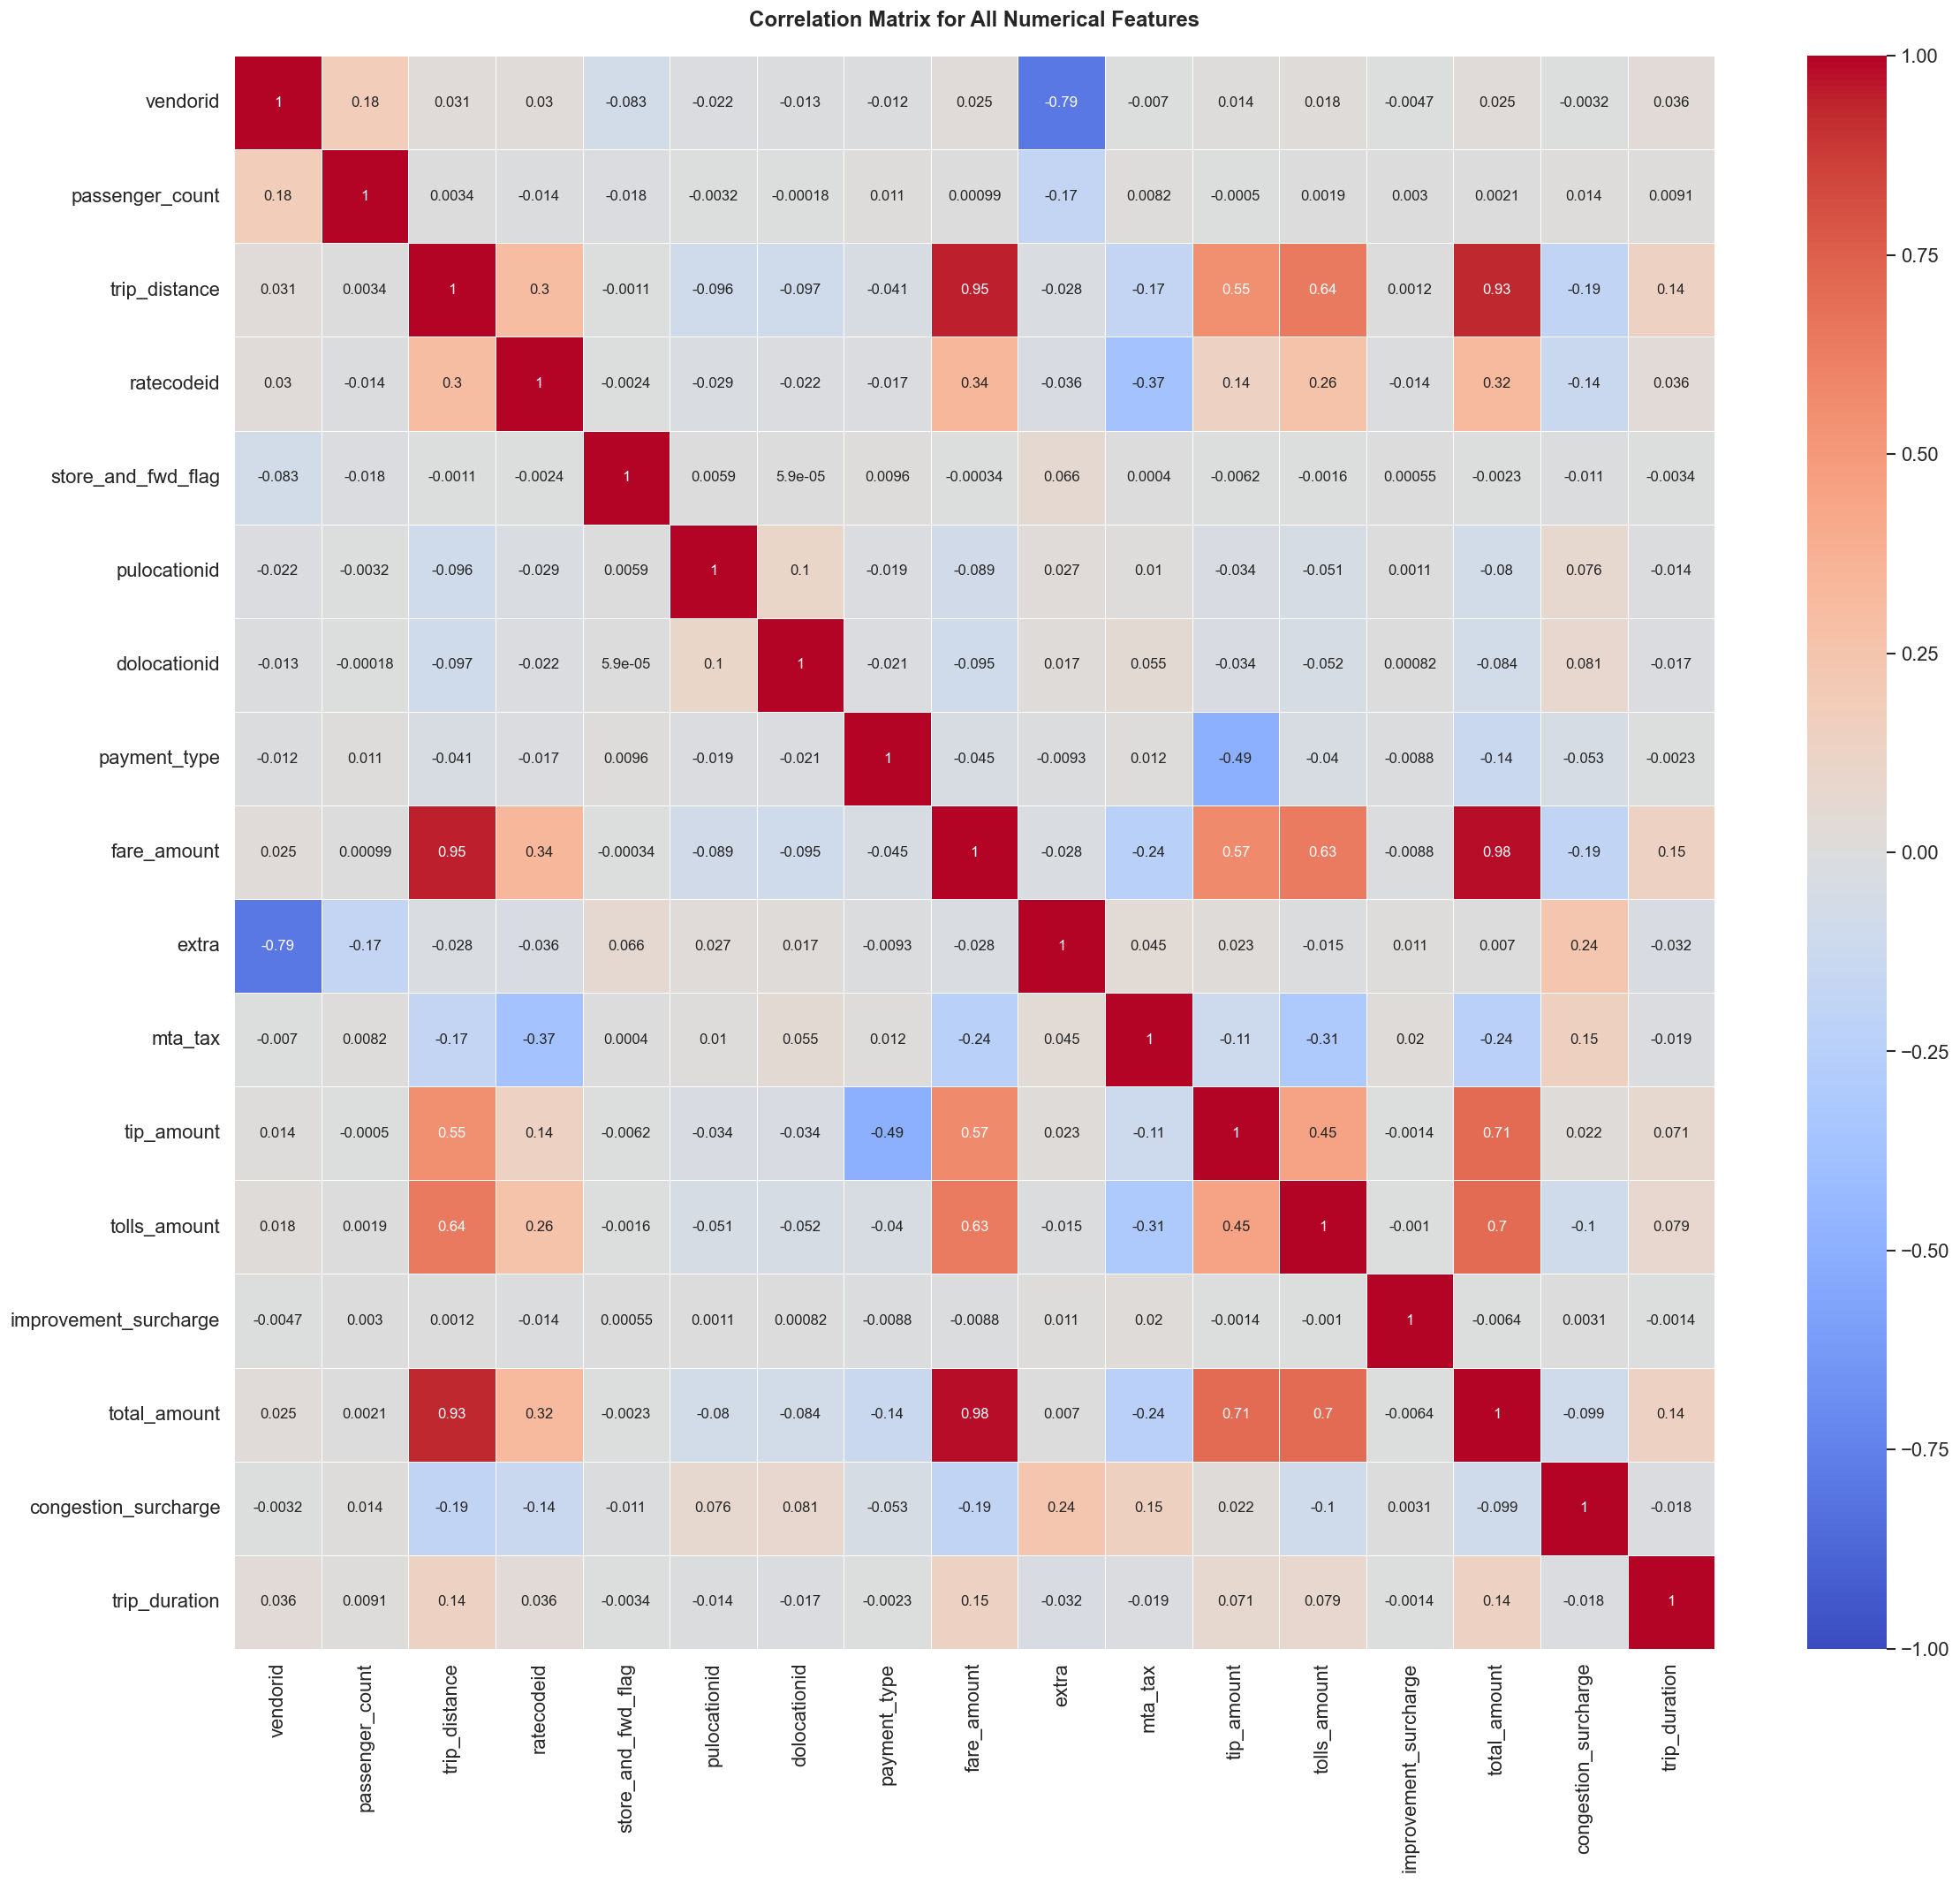

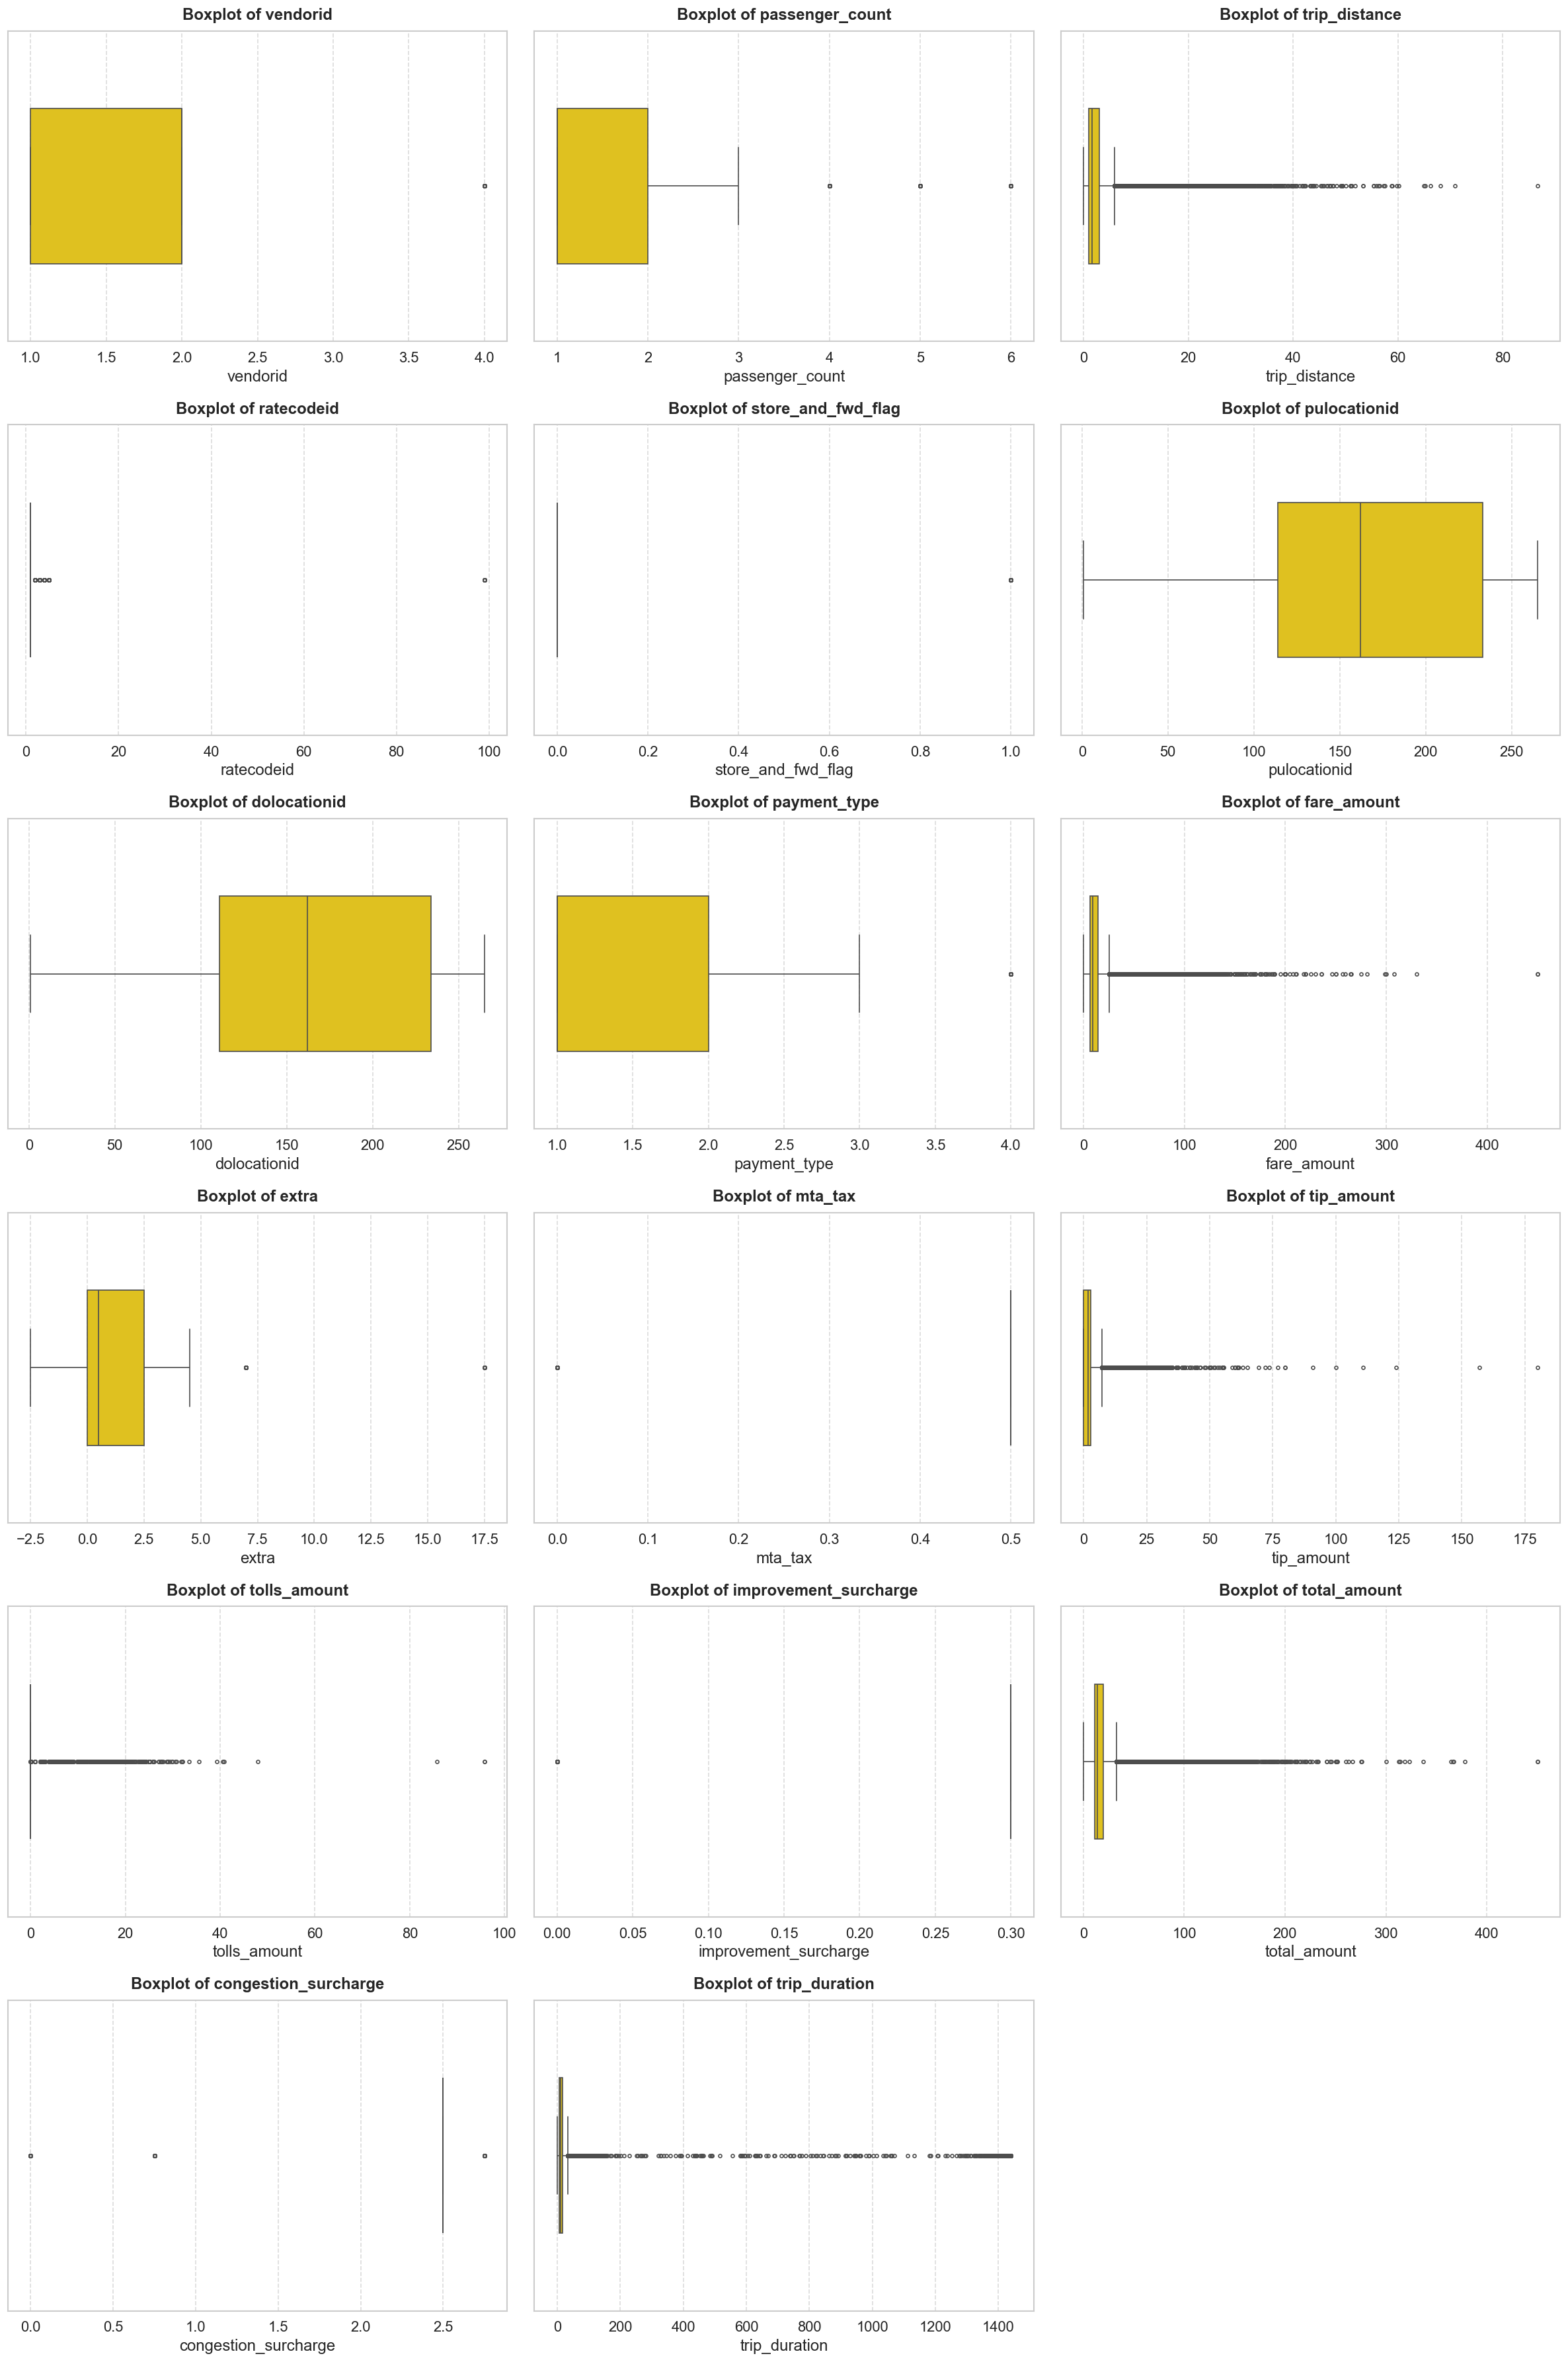

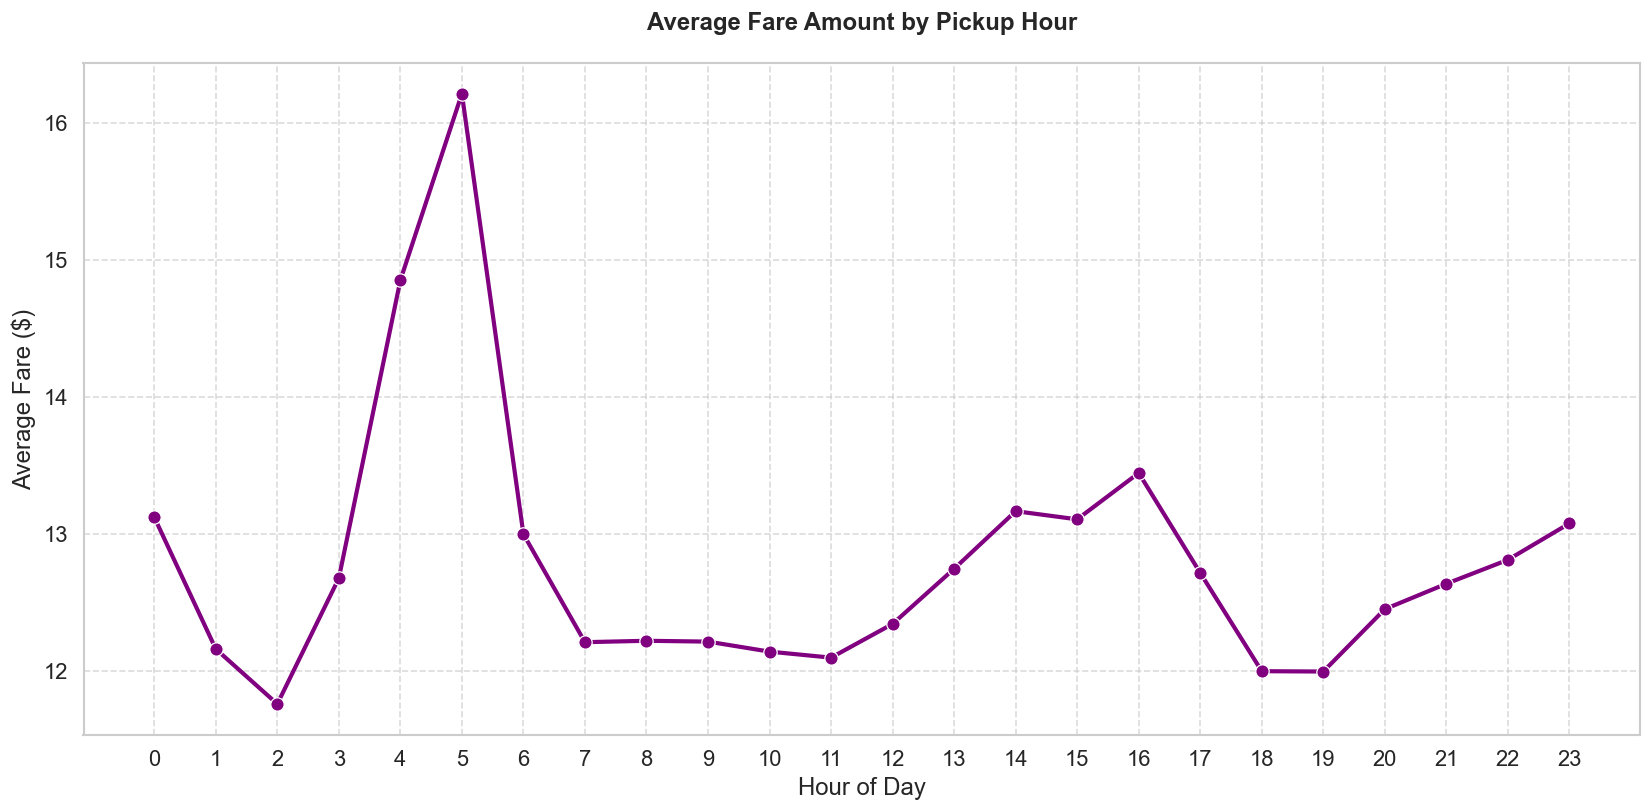

C:\Users\mceka\AppData\Local\Temp\ipykernel_18864\3012736863.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fare_class", data=df, palette="Set2", order=["Class 1", "Class 2", "Class 3", "Class 4"])


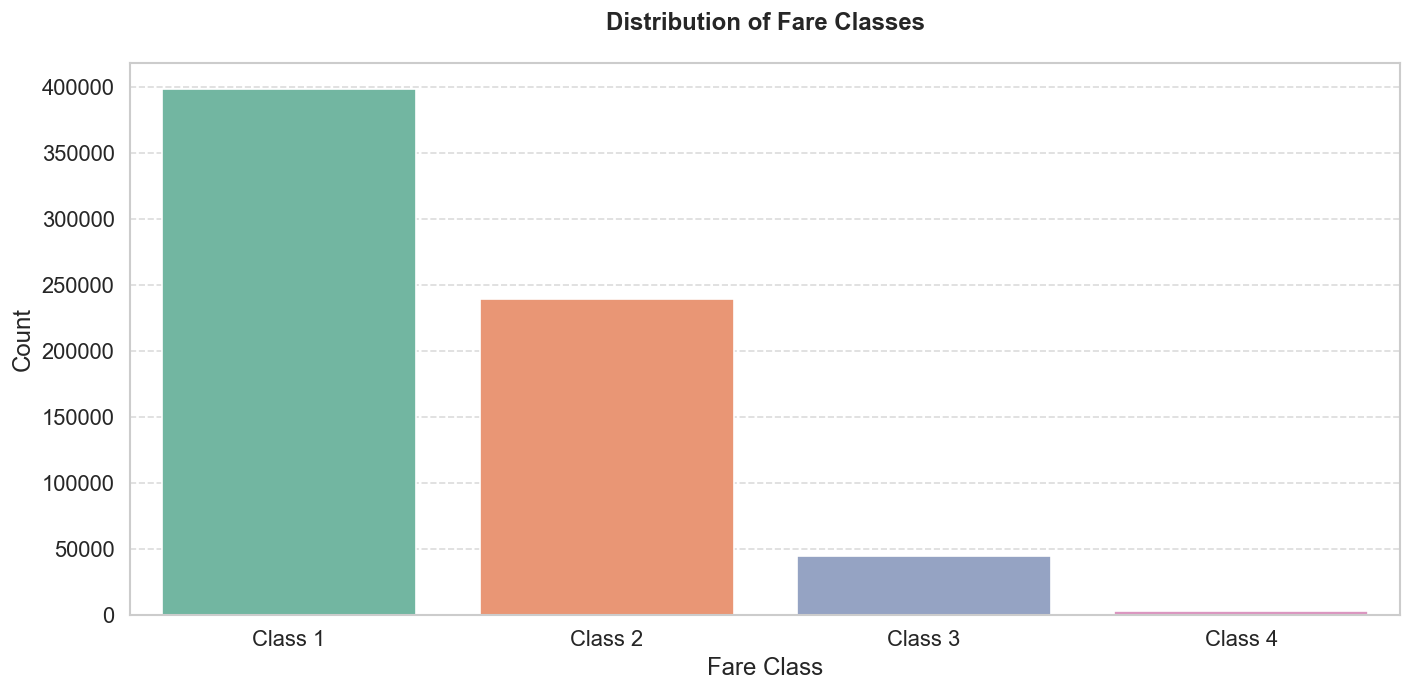

In [9]:
# --- Descriptive Statistics ---

print("Descriptive Statistics:")
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
print(df[numerical_features].describe())


# --- Visualizations ---

# 1. Distribution of All Numerical Features
def plot_feature_distributions(dataframe, numerical_cols):
    n_cols = 3  # Number of subplots per row
    n_rows = (len(numerical_cols) // n_cols) + (len(numerical_cols) % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(numerical_cols):
        sns.histplot(dataframe[col], bins=50, kde=True, ax=axes[i], color="teal")
        axes[i].set_title(f"Distribution of {col}", pad=10, weight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(axis="y", linestyle="--", alpha=0.7)

    # Hide unused subplots
    for j in range(len(numerical_cols), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_feature_distributions(df, numerical_features)

# 2. Correlation Heatmap for All Numerical Features
plt.figure(figsize=(20, 18))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": 10}, linewidths=0.5)
plt.title("Correlation Matrix for All Numerical Features", pad=20, weight="bold")
plt.tight_layout()
plt.show()

# 3. Boxplots for All Numerical Features
def plot_boxplots(dataframe, numerical_cols):
    n_cols = 3  # Number of subplots per row
    n_rows = (len(numerical_cols) // n_cols) + (len(numerical_cols) % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(numerical_cols):
        sns.boxplot(x=dataframe[col], ax=axes[i], color="gold", width=0.5, fliersize=3)
        axes[i].set_title(f"Boxplot of {col}", pad=10, weight="bold")
        axes[i].set_xlabel(col)
        axes[i].grid(axis="x", linestyle="--", alpha=0.7)

    # Hide unused subplots
    for j in range(len(numerical_cols), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_boxplots(df, numerical_features)

# 4. Time Series: Average Fare by Hour (if applicable)
if "tpep_pickup_datetime" in df.columns:
    df["pickup_hour"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.hour
    hourly_fare = df.groupby("pickup_hour")["fare_amount"].mean()
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=hourly_fare.index, y=hourly_fare.values, marker="o", markersize=8, linewidth=2.5, color="purple")
    plt.title("Average Fare Amount by Pickup Hour", pad=20, weight="bold")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Fare ($)")
    plt.grid(linestyle="--", alpha=0.7)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

# 5. Fare Class Distribution (if applicable)
if "fare_class" in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x="fare_class", data=df, palette="Set2", order=["Class 1", "Class 2", "Class 3", "Class 4"])
    plt.title("Distribution of Fare Classes", pad=20, weight="bold")
    plt.xlabel("Fare Class")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Step 3: Dimensionality Reduction

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

# Set NUMBA_NUM_THREADS first (before any imports)
os.environ["NUMBA_NUM_THREADS"] = "8"  # Critical: Set before imports

# --- Feature Engineering ---
# 1. Extract hour from pickup datetime
df["hour"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.hour.astype("Int8")

# 2. Calculate average speed (miles per hour)
df["speed"] = df["trip_distance"] / (df["trip_duration"] / 60)  # miles per hour
df["speed"] = df["speed"].replace([np.inf, -np.inf], np.nan).astype("float32")  # Handle division by zero

# 3. One-hot encode Manhattan pickups and dropoffs
manhattan_ids = [4, 12, 13, 43, 45, 79, 87, 88, 90, 100, 113, 114, 140, 141, 142, 
                 143, 151, 161, 162, 163, 164, 239, 246, 249, 261, 262, 263]  # IDs for Manhattan zones

df["PU_B_Manhattan"] = df["pulocationid"].isin(manhattan_ids).astype("Int8")
df["DO_B_Manhattan"] = df["dolocationid"].isin(manhattan_ids).astype("Int8")

# --- Features for Dimensionality Reduction ---
features = [
    "trip_distance",          # Distance traveled
    "fare_amount",            # Target variable (for visualization)
    "trip_duration",          # Trip duration in minutes
    "passenger_count",        # Number of passengers
    "hour",                   # Hour of pickup (engineered feature)
    "PU_B_Manhattan",         # Pickup in Manhattan (one-hot encoded)
    "DO_B_Manhattan",         # Dropoff in Manhattan (one-hot encoded)
    "speed"                   # Average speed (engineered feature)
]

# Ensure features are numeric and handle missing values
X = df[features].select_dtypes(include=["number"]).dropna()

# Reduce dataset size for faster computation
sample_size = 100_000  # Adjust this based on your system's memory and speed requirements
X_sample = X.sample(n=sample_size, random_state=42)

# --- Preprocessing ---
# Use float32 to reduce memory usage
X_sample = X_sample.astype("float32")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# --- PCA ---
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

# --- UMAP ---
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,           # Smaller n_neighbors for faster computation
    min_dist=0.1,             # Smaller min_dist for faster computation
    metric="euclidean",
    n_jobs=-1,                # Use all available cores
    low_memory=True           # Optimize for memory usage
)
umap_result = umap_model.fit_transform(X_scaled)

# --- Plotting (memory-efficient) ---
plt.figure(figsize=(18, 6))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=df.loc[X_sample.index, "fare_amount"],  # Align fare_amount with scaled data
    cmap="viridis",
    alpha=0.3,
    s=2  # Smaller points for memory efficiency
)
plt.colorbar(label="Fare Amount ($)")
plt.title("PCA Result (Colored by Fare)", fontweight="bold")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# UMAP Plot
plt.subplot(1, 2, 2)
plt.scatter(
    umap_result[:, 0],
    umap_result[:, 1],
    c=df.loc[X_sample.index, "fare_amount"],  # Align fare_amount with scaled data
    cmap="viridis",
    alpha=0.3,
    s=2
)
plt.colorbar(label="Fare Amount ($)")
plt.title("UMAP Result (Colored by Fare)", fontweight="bold")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

c:\Users\mceka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mceka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pynndescent\rp_trees.py:1399: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your graph_data, and this may take longer than normal to compute.
  warn(


RuntimeError: Cannot set NUMBA_NUM_THREADS to a different value once the threads have been launched (currently have 8, trying to set 12)

# Step 4: Hypothesis Testing


Hypothesis Test: Trip Distance vs Fare Amount
T-statistic: -1030.1103, P-value: 0.0000
Levene's Test for Equal Variances
Levene Statistic: 178602.3515, P-value: 0.0000
Reject the null hypothesis: Trip distance significantly affects fare amount.


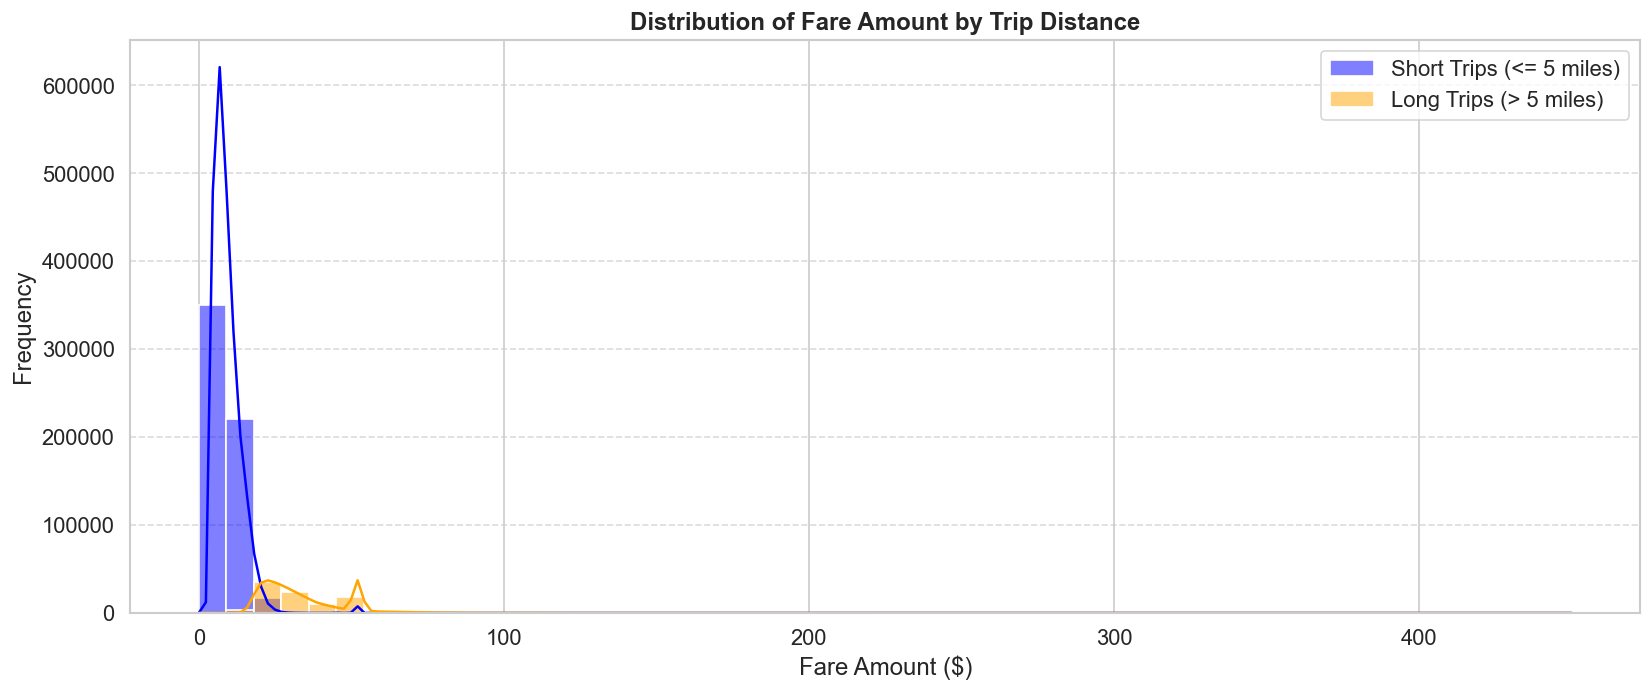

In [11]:
# --- Hypothesis Testing ---
# Hypothesis: Trip distance affects fare amount
short_trips = df[df["trip_distance"] <= 5]["fare_amount"]
long_trips = df[df["trip_distance"] > 5]["fare_amount"]

# Perform t-test
t_stat, p_value = ttest_ind(short_trips, long_trips)
print(f"\nHypothesis Test: Trip Distance vs Fare Amount")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

# Perform Levene's test for equal variances
levene_stat, levene_p_value = levene(short_trips, long_trips)
print(f"Levene's Test for Equal Variances")
print(f"Levene Statistic: {levene_stat:.4f}, P-value: {levene_p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Trip distance significantly affects fare amount.")
else:
    print("Fail to reject the null hypothesis.")

# Visualize distributions of fare_amount for short and long trips
plt.figure(figsize=(14, 6))
sns.histplot(short_trips, bins=50, kde=True, label="Short Trips (<= 5 miles)", color="blue", alpha=0.5)
sns.histplot(long_trips, bins=50, kde=True, label="Long Trips (> 5 miles)", color="orange", alpha=0.5)
plt.title("Distribution of Fare Amount by Trip Distance", weight="bold")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 5: Feature Engineering

In [12]:
import os
import pandas as pd
import numpy as np

#  Ensure the dataset (df) is loaded
if "df" not in globals():
    raise ValueError("Error: DataFrame 'df' is not loaded. Load your dataset first!")

# Check required columns before proceeding
required_columns = {
    "tpep_pickup_datetime", "trip_distance", "trip_duration",
    "fare_amount", "passenger_count", "pulocationid", "dolocationid",
    "ratecodeid", "payment_type"
}
missing_cols = required_columns - set(df.columns)
if missing_cols:
    raise ValueError(f"Error: Missing columns in dataframe: {missing_cols}")

# --- Time-Based Features ---
df["pickup_day"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month

#  Ensure 'hour' column exists before binning
df["hour"] = df["tpep_pickup_datetime"].dt.hour

# Binning pickup_hour into categories
df["pickup_time_of_day"] = pd.cut(
    df["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

# --- Speed Feature ---
df["average_speed"] = df["trip_distance"] / (df["trip_duration"] / 60)  # miles per hour
df["average_speed"] = df["average_speed"].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Categorical Encoding ---
df["RateCodeID"] = df["ratecodeid"].astype("category").cat.codes
df["payment_type"] = df["payment_type"].astype("category").cat.codes

# --- Location Mapping ---
file_path = "taxi_zone_lookup.csv"  

if os.path.exists(file_path):
    zone_lookup = pd.read_csv(file_path)
    zone_dict = dict(zip(zone_lookup["LocationID"], zone_lookup["Zone"]))
    borough_dict = dict(zip(zone_lookup["LocationID"], zone_lookup["Borough"]))
    
    df["PULocationID"] = df["pulocationid"].map(zone_dict).fillna("Unknown")
    df["DOLocationID"] = df["dolocationid"].map(zone_dict).fillna("Unknown")
    df["PU_borough"] = df["pulocationid"].map(borough_dict).fillna("Unknown")
    df["DO_borough"] = df["dolocationid"].map(borough_dict).fillna("Unknown")

    # One-hot encode pickup/dropoff boroughs
    df = pd.get_dummies(df, columns=["PU_borough", "DO_borough"], prefix=["PU_B", "DO_B"], drop_first=True)

    # --- Additional Features ---
    # Distance to/from Manhattan
    manhattan_id = zone_lookup[zone_lookup["Borough"] == "Manhattan"]["LocationID"].values
    df["is_pickup_manhattan"] = df["pulocationid"].isin(manhattan_id).astype(int)
    df["is_dropoff_manhattan"] = df["dolocationid"].isin(manhattan_id).astype(int)

    # Distance to/from Airports
    airport_ids = zone_lookup[zone_lookup["service_zone"] == "Airports"]["LocationID"].values
    df["is_pickup_airport"] = df["pulocationid"].isin(airport_ids).astype(int)
    df["is_dropoff_airport"] = df["dolocationid"].isin(airport_ids).astype(int)

else:
    print(f" Warning: File '{file_path}' not found! Location mapping features will be skipped.")

# --- Final Feature List ---
print("\nFinal Features:")
print(df.columns.tolist())



Final Features:
['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag', 'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'trip_duration', 'fare_class', 'pickup_hour', 'hour', 'speed', 'PU_B_Manhattan', 'DO_B_Manhattan', 'pickup_day', 'pickup_month', 'pickup_time_of_day', 'average_speed', 'RateCodeID', 'PULocationID', 'DOLocationID', 'PU_B_Brooklyn', 'PU_B_EWR', 'PU_B_Manhattan', 'PU_B_Queens', 'PU_B_Staten Island', 'PU_B_Unknown', 'DO_B_Brooklyn', 'DO_B_EWR', 'DO_B_Manhattan', 'DO_B_Queens', 'DO_B_Staten Island', 'DO_B_Unknown', 'is_pickup_manhattan', 'is_dropoff_manhattan', 'is_pickup_airport', 'is_dropoff_airport']


In [13]:
print(*df.columns.tolist(), sep='\n')

vendorid
tpep_pickup_datetime
tpep_dropoff_datetime
passenger_count
trip_distance
ratecodeid
store_and_fwd_flag
pulocationid
dolocationid
payment_type
fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
trip_duration
fare_class
pickup_hour
hour
speed
PU_B_Manhattan
DO_B_Manhattan
pickup_day
pickup_month
pickup_time_of_day
average_speed
RateCodeID
PULocationID
DOLocationID
PU_B_Brooklyn
PU_B_EWR
PU_B_Manhattan
PU_B_Queens
PU_B_Staten Island
PU_B_Unknown
DO_B_Brooklyn
DO_B_EWR
DO_B_Manhattan
DO_B_Queens
DO_B_Staten Island
DO_B_Unknown
is_pickup_manhattan
is_dropoff_manhattan
is_pickup_airport
is_dropoff_airport


# Step 6: Model Selection

In [14]:
# --- Model Selection ---
# --- Define Features and Targets ---
# Features for regression and classification tasks

X_reg = df[[
    "trip_distance",          # Distance traveled
    "hour",            # Hour of pickup
    "average_speed",          # Average speed during the trip
    "RateCodeID",             # Encoded rate code
    "payment_type",           # Encoded payment type
    "is_weekend",             # Weekend flag
    "pickup_time_of_day",     # Time of day category
    "is_pickup_manhattan",    # Pickup in Manhattan
    "is_dropoff_manhattan",   # Dropoff in Manhattan
    "is_pickup_airport",      # Pickup at airport
    "is_dropoff_airport",     # Dropoff at airport
    "PU_B_Brooklyn",          # Pickup borough: Brooklyn
    "PU_B_Manhattan",         # Pickup borough: Manhattan
    "PU_B_Queens",            # Pickup borough: Queens
    "PU_B_Staten Island",     # Pickup borough: Staten Island
    "PU_B_Unknown",           # Pickup borough: Unknown
    "DO_B_Brooklyn",          # Dropoff borough: Brooklyn
    "DO_B_Manhattan",         # Dropoff borough: Manhattan
    "DO_B_Queens",            # Dropoff borough: Queens
    "DO_B_Staten Island",     # Dropoff borough: Staten Island
    "DO_B_Unknown"            # Dropoff borough: Unknown
]]

# Regression target: `fare_amount`
y_reg = df["fare_amount"]

# Classification target: `fare_class` (predefined fare ranges)
y_clf = df["fare_class"]

# --- Split Data into Training and Testing Sets ---
# Regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Classification split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_reg, y_clf, test_size=0.2, random_state=42
)

# --- Regression Models ---
regression_models = {
    "Linear Regression": LinearRegression(),  # Baseline regression model
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),  # Non-linear model
    "Random Forest Regressor": RandomForestRegressor(random_state=42)  # Ensemble model
}

# --- Classification Models ---
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Baseline classification model
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),  # Non-linear model
    "Random Forest Classifier": RandomForestClassifier(random_state=42)  # Ensemble model
}

# --- Validation Method: K-Fold Cross-Validation ---
print("Regression Model Evaluation:")
for name, model in regression_models.items():
    scores = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(-scores)
    print(f"{name} Cross-Validation RMSE: {rmse_scores.mean():.2f}")

print("\nClassification Model Evaluation:")
for name, model in classification_models.items():
    scores = cross_val_score(model, X_train_clf, y_train_clf, cv=5, scoring="accuracy")
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.2f}")

# --- Justification for Validation Method ---
"""
K-Fold Cross-Validation (k=5) is chosen to:
- Ensure robust performance estimation by averaging results across 5 subsets.
- Avoid overfitting by testing on multiple validation sets.
- Handle the large dataset efficiently without data leakage.
"""

# --- Model Suitability Justification ---
"""
1. **Linear Regression**: Baseline model for regression tasks; assumes linear relationships between features and target.
2. **Decision Tree Regressor/Classifier**: Captures non-linear relationships and interactions between features.
3. **Random Forest Regressor/Classifier**: Improves accuracy through ensemble learning (bagging) and handles overfitting better than individual decision trees.
4. **Logistic Regression**: Baseline for classification tasks; works well for linearly separable classes.
5. **Ensemble Methods**: Random Forest is chosen for its ability to generalize well and reduce variance compared to individual decision trees.
"""

KeyError: "['is_weekend'] not in index"

In [ ]:
# --- Model Selection ---
# --- Define Features and Targets ---

# Features for regression and classification tasks
X_reg = df[[
    "trip_distance",          # Distance traveled
    "hour",                   # Hour of pickup (engineered feature)
    "speed",                  # Average speed during the trip (renamed from `average_speed`)
    "RateCodeID",             # Encoded rate code
    "payment_type",           # Encoded payment type
    "is_pickup_manhattan",    # Pickup in Manhattan
    "is_dropoff_manhattan",   # Dropoff in Manhattan
    "is_pickup_airport",      # Pickup at airport
    "is_dropoff_airport",     # Dropoff at airport
    "PU_B_Brooklyn",          # Pickup borough: Brooklyn
    "PU_B_Manhattan",         # Pickup borough: Manhattan
    "PU_B_Queens",            # Pickup borough: Queens
    "PU_B_Staten Island",     # Pickup borough: Staten Island
    "PU_B_Unknown",           # Pickup borough: Unknown
    "DO_B_Brooklyn",          # Dropoff borough: Brooklyn
    "DO_B_Manhattan",         # Dropoff borough: Manhattan
    "DO_B_Queens",            # Dropoff borough: Queens
    "DO_B_Staten Island",     # Dropoff borough: Staten Island
    "DO_B_Unknown"            # Dropoff borough: Unknown
]]

# Regression target: `fare_amount`
y_reg = df["fare_amount"]

# Classification target: `fare_class` (predefined fare ranges)
y_clf = df["fare_class"]

# --- Split Data into Training and Testing Sets ---
from sklearn.model_selection import train_test_split

# Regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Classification split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_reg, y_clf, test_size=0.2, random_state=42
)

# --- Regression Models ---
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regression_models = {
    "Linear Regression": LinearRegression(),  # Baseline regression model
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),  # Non-linear model
    #"Random Forest Regressor": RandomForestRegressor(random_state=42)  # Ensemble model
}

# --- Classification Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Baseline classification model
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),  # Non-linear model
    #"Random Forest Classifier": RandomForestClassifier(random_state=42)  # Ensemble model
}

# --- Validation Method: K-Fold Cross-Validation ---
print("Regression Model Evaluation:")
for name, model in regression_models.items():
    scores = cross_val_score(model, X_train_reg, y_train_reg, cv=5, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(-scores)
    print(f"{name} Cross-Validation RMSE: {rmse_scores.mean():.2f}")

print("\nClassification Model Evaluation:")
for name, model in classification_models.items():
    scores = cross_val_score(model, X_train_clf, y_train_clf, cv=5, scoring="accuracy")
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.2f}")

# --- Justification for Validation Method ---
"""
K-Fold Cross-Validation (k=5) is chosen to:
- Ensure robust performance estimation by averaging results across 5 subsets.
- Avoid overfitting by testing on multiple validation sets.
- Handle the large dataset efficiently without data leakage.
"""

# --- Model Suitability Justification ---
"""
1. **Linear Regression**: Baseline model for regression tasks; assumes linear relationships between features and target.
2. **Decision Tree Regressor/Classifier**: Captures non-linear relationships and interactions between features.
3. **Random Forest Regressor/Classifier**: Improves accuracy through ensemble learning (bagging) and handles overfitting better than individual decision trees.
4. **Logistic Regression**: Baseline for classification tasks; works well for linearly separable classes.
5. **Ensemble Methods**: Random Forest is chosen for its ability to generalize well and reduce variance compared to individual decision trees.
"""